In [1]:
!git lfs install

Git LFS initialized.


In [2]:
!git clone https://huggingface.co/datasets/MushanW/GLOBE


Cloning into 'GLOBE'...
Updating files:  80% (90/112)
Updating files:  81% (91/112)
Updating files:  82% (92/112)
Updating files:  83% (93/112)
Updating files:  84% (95/112)
Updating files:  85% (96/112)
Updating files:  86% (97/112)
Updating files:  87% (98/112)
Updating files:  88% (99/112)
Updating files:  89% (100/112)
Updating files:  90% (101/112)
Updating files:  91% (102/112)
Updating files:  92% (104/112)
Updating files:  93% (105/112)
Updating files:  94% (106/112)
Updating files:  95% (107/112)
Updating files:  96% (108/112)
Updating files:  97% (109/112)
Updating files:  98% (110/112)
Updating files:  99% (111/112)
Updating files: 100% (112/112)
Updating files: 100% (112/112), done.
Filtering content:   1% (2/110)
Filtering content:   1% (2/110), 868.15 MiB | 65.11 MiB/s
Filtering content:   2% (3/110), 868.15 MiB | 65.11 MiB/s
Filtering content:   2% (3/110), 1.27 GiB | 71.12 MiB/s  
Filtering content:   3% (4/110), 1.27 GiB | 71.12 MiB/s
Filtering content:   3% (4/110), 1

In [1]:
import pandas as pd

In [2]:
import pyarrow.parquet as pq

In [3]:
data=pd.read_parquet("GLOBE//data//train-00006-of-00108.parquet", engine='pyarrow')
data.head(2)

,audio,speaker_id,transcript,accent,duration,age,gender
0,"{'bytes': b'fLaC\x00\x00\x00""\t\x00\t\x00\x00\...",S_016415,giant's kettles can also be formed while the s...,"German English,Non native speaker",3.7,fourties,male
1,"{'bytes': b'fLaC\x00\x00\x00""\t\x00\t\x00\x00\...",S_023051,easton high school was closed due to school un...,United States English,3.2,twenties,male


In [7]:
data['audio'][0]['path']

'000011.flac'

In [4]:
data.shape

(5298, 7)

In [4]:
data.accent.value_counts()

accent
United States English                                                                                                   3892
England English                                                                                                          717
India and South Asia (India, Pakistan, Sri Lanka)                                                                        201
Canadian English                                                                                                         128
Australian English                                                                                                       118
Hong Kong English                                                                                                         81
German English,Non native speaker                                                                                         77
Scottish English                                                                                                      

In [4]:
from IPython.display import Audio

In [5]:
# Function to play audio
def play_audio(audio_path):
    return Audio(audio_path,rate=44100,autoplay=True)

In [6]:


# Example usage: playing the first audio in the dataframe
audio_path = data.iloc[0]['audio']
type(play_audio(audio_path['bytes']))

IPython.lib.display.Audio

In [8]:
type(audio_path['path'])

str

In [9]:
import numpy as np

In [10]:
import librosa
import librosa.display
import soundfile as sf
import io
from tqdm import tqdm
import os
from concurrent.futures import ProcessPoolExecutor
import re

In [11]:
import matplotlib.pyplot as plt

In [12]:
def audio_to_spectrogram(audio_bytes, sr=22050):
    # Load audio data from bytes
    audio_data, sample_rate = sf.read(io.BytesIO(audio_bytes), dtype='float32')
    
    # Generate spectrogram
    S = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

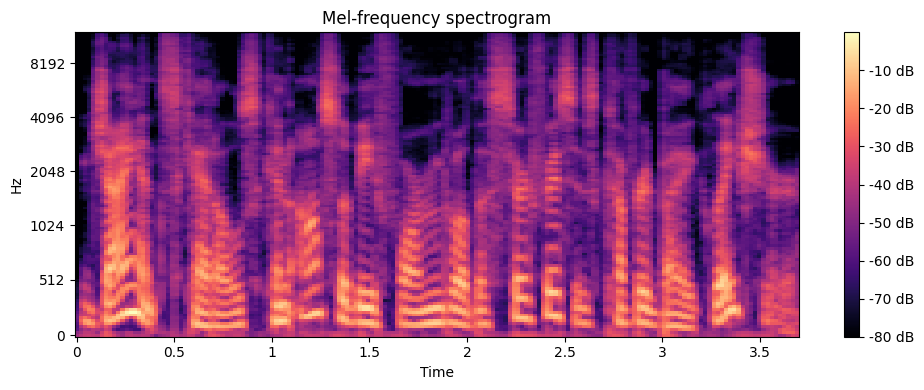

In [13]:
audio_to_spectrogram(audio_path['bytes'])

In [14]:
os.listdir('GLOBE\data')

['train-00000-of-00108.parquet',
 'train-00001-of-00108.parquet',
 'train-00002-of-00108.parquet',
 'train-00003-of-00108.parquet',
 'train-00004-of-00108.parquet',
 'train-00005-of-00108.parquet',
 'train-00006-of-00108.parquet',
 'train-00007-of-00108.parquet',
 'train-00008-of-00108.parquet',
 'train-00009-of-00108.parquet',
 'train-00010-of-00108.parquet',
 'train-00011-of-00108.parquet',
 'train-00012-of-00108.parquet',
 'train-00013-of-00108.parquet',
 'train-00014-of-00108.parquet',
 'train-00015-of-00108.parquet',
 'train-00016-of-00108.parquet',
 'train-00017-of-00108.parquet',
 'train-00018-of-00108.parquet',
 'train-00019-of-00108.parquet',
 'train-00020-of-00108.parquet',
 'train-00021-of-00108.parquet',
 'train-00022-of-00108.parquet',
 'train-00023-of-00108.parquet',
 'train-00024-of-00108.parquet',
 'train-00025-of-00108.parquet',
 'train-00026-of-00108.parquet',
 'train-00027-of-00108.parquet',
 'train-00028-of-00108.parquet',
 'train-00029-of-00108.parquet',
 'train-00

In [22]:
def sanitize_folder_name(name):
    return re.sub(r'[\\/*?:"<>|]', "_", name)

In [23]:
def audio_to_melspectrogram(audio_bytes, sr):
    try:
        audio_data, sample_rate = sf.read(io.BytesIO(audio_bytes), dtype='float32')
        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

In [24]:
def save_spectrogram(spectrogram, output_path):
    if spectrogram is not None:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Ensure directory exists
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram, sr=22050, x_axis=None, y_axis=None)
        plt.axis('off')  # Turn off the axis
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

In [26]:
parquet_files_dir = 'GLOBE\data'
parquet_files = [os.path.join(parquet_files_dir, f) for f in os.listdir(parquet_files_dir) if f.endswith('.parquet')]

output_base_dir = 'GLOBE\data\save_spectrograms'
os.makedirs(output_base_dir, exist_ok=True)

In [27]:
def process_batch(parquet_batch):
    df = pd.concat(parquet_batch, ignore_index=True)
    
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            audio_bytes = row['audio']['bytes']
            accent = sanitize_folder_name(row['accent'])
            speaker_id = row['speaker_id']
            output_path = os.path.join(output_base_dir, accent, f"{speaker_id}_{index}.png")
            mel_spectrogram = audio_to_melspectrogram(audio_bytes, sr=22050)
            save_spectrogram(mel_spectrogram, output_path)
        except Exception as e:
            print(f"Error processing row {index}: {e}")

In [29]:
batch_size = 10
parquet_batches = [parquet_files[i:i + batch_size] for i in range(0, len(parquet_files), batch_size)]

for batch in parquet_batches:
    parquet_batch = [pd.read_parquet(file) for file in batch]
    process_batch(parquet_batch)

  6%|▌         | 3024/52980 [13:12<6:09:49,  2.25it/s] 